In [38]:
import platform
print(f"platform.python_version(): {platform.python_version()}")

import os
import scipy
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

import matplotlib.pyplot as plt

print(f"np.version.version: {np.version.version}")
print(f"scipy.__version__: {scipy.__version__}")
print(f"tf.__version__: {tf.__version__}")
# 確認GPU是否可用
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

platform.python_version(): 3.9.13
np.version.version: 1.22.4
scipy.__version__: 1.7.3
tf.__version__: 2.10.1
tf.config.list_physical_devices('GPU'): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
npy_file_list = glob(f"..\\..\\data\\mfccEduVer\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")
# npy_file_list

type(npy_file_list): <class 'list'>
len(npy_file_list): 39423


In [22]:
df = pd.read_csv(filepath_or_buffer=f".\\pinyin_classes_layer_1_table.csv", encoding='utf-8')
df

,bopomofo,pinyin,hu_yin,she2_yin,hu_yin_label,she2_yin_label,class_label
0,ㄓ,zhi,純聲符,翹舌音,0,5,0
1,ㄔ,chi,純聲符,翹舌音,0,5,0
2,ㄕ,shi,純聲符,翹舌音,0,5,0
3,ㄖ,ri,純聲符,翹舌音,0,5,0
4,ㄗ,zi,純聲符,平舌音,0,6,1
...,...,...,...,...,...,...,...
402,ㄒㄩㄣ,xun,撮口呼,舌面音,4,4,20
403,ㄩㄥ,yong,撮口呼,純韻符,4,0,18
404,ㄐㄩㄥ,jiong,撮口呼,舌面音,4,4,20
405,ㄑㄩㄥ,qiong,撮口呼,舌面音,4,4,20


In [28]:
label_pinyin_list = []

for npy_file in npy_file_list:
    label_pinyin = npy_file[npy_file.find("_") + 1:npy_file.find(".npy")]
    label_pinyin_list.append(label_pinyin)

# 將list()轉換成np.array()
label_pinyin_list = np.array(label_pinyin_list)

print(f"type(label_pinyin_list): {type(label_pinyin_list)}")
print(f"label_pinyin_list.shape: {label_pinyin_list.shape}")
# label_pinyin_list

type(label_pinyin_list): <class 'numpy.ndarray'>
label_pinyin_list.shape: (39423,)


In [35]:
label_int_list = []
for label_pinyin in label_pinyin_list:
    class_label_pinyin = label_pinyin[:-1] if label_pinyin[-1].isdigit() else label_pinyin
    if class_label_pinyin in list(df["pinyin"]):
        label_int = df.loc[list(df["pinyin"]).index(class_label_pinyin), "class_label"]
        label_int_list.append(label_int)

label_int_list = np.array(label_int_list)
print(f"label_int_list.shape => {label_int_list.shape}")
# label_int_list

label_int_list.shape => (39007,)


In [34]:
mfcc_list = []

for npy_file in tqdm(npy_file_list):
    label_pinyin = npy_file[npy_file.find("_") + 1:npy_file.find(".npy")]
    class_label_pinyin = label_pinyin[:-1] if label_pinyin[-1].isdigit() else label_pinyin
    if class_label_pinyin in list(df["pinyin"]):
        mfcc = np.load(file=npy_file)
        mfcc_list.append(mfcc)

# 將list()轉換成np.array()
mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

# 不要印出 ipynb會爆炸
# mfcc_list

100%|██████████| 39423/39423 [02:03<00:00, 318.87it/s]


type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (39007, 13, 44)


In [36]:
scaler = StandardScaler()
# 因為標準器只能fit 2維的資料所以要將3維的mfcc資料集reshape成2維
# mfcc_data_nums: k
# mfcc_row: n
# mfcc_column: m
# (k, n, m) => (k * n, m)
scaler.fit(mfcc_list.reshape((mfcc_list.shape[0] * mfcc_list.shape[1], mfcc_list.shape[2])))

mfcc_list_scaled = []
for mfcc in mfcc_list:
    mfcc_list_scaled.append(scaler.transform(mfcc))

# 將list()轉換成np.array()
mfcc_list_scaled = np.array(mfcc_list_scaled)

print(f"type(mfcc_list_scaled): {type(mfcc_list_scaled)}")
print(f"mfcc_list_scaled.shape: {mfcc_list_scaled.shape}")

# 不要印出 ipynb會爆炸
# mfcc_scaled

type(mfcc_list_scaled): <class 'numpy.ndarray'>
mfcc_list_scaled.shape: (39007, 13, 44)


In [37]:
def get_cnn_model(input_shape, num_classes, learning_rate=0.001, num_filters=32, dense_units=256):
    cnn_model = Sequential()

    # 第一層捲積層
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 第二層捲積層
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 第三層捲積層
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 展平
    cnn_model.add(Flatten())
    
    # 第一層全連接層
    cnn_model.add(Dense(dense_units))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    
    # 第二層全連接層
    cnn_model.add(Dense(dense_units * 2))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    
    # 第三層全連接層(長度同為1467個label)
    cnn_model.add(Dense(num_classes))
    
    # 表示為機率
    cnn_model.add(Activation('softmax'))

    cnn_model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return cnn_model

In [40]:
best_params = json.load(open(f"..\\..\\grid_search\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

In [41]:
channel = 1
verbose = 2
num_classes = len(df["class_label"])
test_size = 0.2
mfcc_dim_1 = mfcc_list.shape[1]
mfcc_dim_2 = mfcc_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


In [42]:
X = mfcc_list_scaled
y = label_int_list

# 將int label轉換成二進制one hot標籤
y_one_hot = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=test_size, random_state=42)

X_train = X_train.reshape(X_train.shape[0], mfcc_dim_1, mfcc_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], mfcc_dim_1, mfcc_dim_2, channel)

In [43]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes, learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/300
244/244 - 8s - loss: 2.1532 - accuracy: 0.4376 - val_loss: 3.0226 - val_accuracy: 0.1278 - 8s/epoch - 31ms/step
Epoch 2/300
244/244 - 5s - loss: 1.0626 - accuracy: 0.6488 - val_loss: 1.4782 - val_accuracy: 0.5135 - 5s/epoch - 20ms/step
Epoch 3/300
244/244 - 5s - loss: 0.8356 - accuracy: 0.7227 - val_loss: 1.0467 - val_accuracy: 0.6455 - 5s/epoch - 20ms/step
Epoch 4/300
244/244 - 5s - loss: 0.6992 - accuracy: 0.7694 - val_loss: 0.8377 - val_accuracy: 0.7228 - 5s/epoch - 20ms/step
Epoch 5/300
244/244 - 5s - loss: 0.6018 - accuracy: 0.8008 - val_loss: 0.8319 - val_accuracy: 0.7284 - 5s/epoch - 20ms/step
Epoch 6/300
244/244 - 5s - loss: 0.5157 - accuracy: 0.8296 - val_loss: 0.9223 - val_accuracy: 0.7007 - 5s/epoch - 20ms/step
Epoch 7/300
244/244 - 5s - loss: 0.4386 - accuracy: 0.8548 - val_loss: 0.7914 - val_accuracy: 0.7512 - 5s/epoch - 21ms/step
Epoch 8/300
244/244 - 5s - loss: 0.3771 - accuracy: 0.8762 - val_loss: 0.8057 - val_accuracy: 0.7407 - 5s/epoch - 21ms/step
Epoch 9/

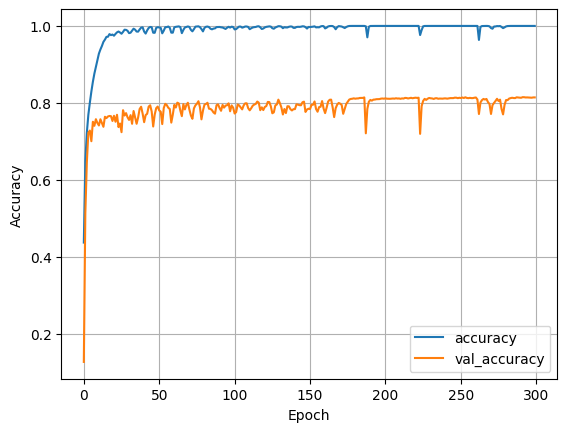

In [44]:
accuracies = model_train_info.history['accuracy']
val_accuracies = model_train_info.history['val_accuracy']

plt.plot(list(range(epochs)), accuracies, label = 'accuracy')
plt.plot(list(range(epochs)), val_accuracies, label = 'val_accuracy')
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, epochs + 1, 50)))
plt.show()

In [45]:
print(f"資料: {mfcc_list_scaled.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (39007, 13, 44)
最高準確率: 0.8150474429130554


In [46]:
model.save(f".\\class_layer_1_cnn_model.h5")